# A Simple Model

My first stab at this task will be to implement an **Autoencoder + Gaussian Process** model, as a baseline.

In [1]:
%matplotlib inline

#Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Sklearn Imports
from sklearn.cross_validation import train_test_split

In [2]:
df = pd.read_csv('train.csv',header=None)
df.head()

0     1     2     3     4     5     6     7     8     9     ...   1559  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   1560  1561  1562  1563  1564  1565  1566  1567  1568  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1569 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40824 entries, 0 to 40823
Columns: 1569 entries, 0 to 1568
dtypes: float64(1569)
memory usage: 488.7 MB


In [4]:
# Data load function
def load_data(filename):
    data   = pd.read_csv(filename,header=None)
    x_data = data.iloc[:,:-1].values
    y_data = data.iloc[:,-1].values
    print 'X shape:', x_data.shape
    print 'Y shape:', y_data.shape
    return x_data,y_data

In [6]:
filename = 'train.csv'
x_train,y_train=load_data(filename)
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.3,random_state=32)

X shape: (40824, 1568)
Y shape: (40824,)


## Autoencoder Model

In [7]:
# Keras Imports
# Keras Imports
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from keras.layers import Flatten, Reshape, GaussianDropout
from keras import backend as K
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [8]:
# Parameters
ndim = x_train.shape[1]
E1   = 512
E2   = 200
E3   = 50

In [9]:
# Build Autoencoder
def build_model():
    x = Input(shape=(ndim,),name='Input')
    h = Dense(E1,activation='relu',name='Encode1')(x)
    h = Dense(E2,activation='relu',name='Encode2')(h)
    e = Dense(E3,activation='relu',name='Embedding')(h)
    h = Dense(E2,activation='relu',name='Decode1')(e)
    h = Dense(E1,activation='relu',name='Decode2')(h)
    y = Dense(ndim,activation='linear',name='Output')(h)
    tmodel = Model(x,y)
    emodel = Model(x,e)
    return tmodel, emodel

In [10]:
# Compile Model
model,encoder = build_model()
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1568)              0         
_________________________________________________________________
Encode1 (Dense)              (None, 512)               803328    
_________________________________________________________________
Encode2 (Dense)              (None, 200)               102600    
_________________________________________________________________
Embedding (Dense)            (None, 50)                10050     
_________________________________________________________________
Decode1 (Dense)              (None, 200)               10200     
_________________________________________________________________
Decode2 (Dense)              (None, 512)               102912    
_________________________________________________________________
Output (Dense)               (None, 1568)              804384    
Total para

In [40]:
# Train Model
log = model.fit(x_train, x_train,
              batch_size=20,
              epochs=20,
              shuffle=True,
              validation_data=(x_valid,x_valid))

Train on 28576 samples, validate on 12248 samples
Epoch 1/20
28576/28576 [==============================] - 30s - loss: 0.0286 - val_loss: 0.0239
Epoch 2/20
28576/28576 [==============================] - 29s - loss: 0.0348 - val_loss: 0.0122
Epoch 3/20
28576/28576 [==============================] - 31s - loss: 0.0442 - val_loss: 0.0187
Epoch 4/20
28576/28576 [==============================] - 29s - loss: 0.0324 - val_loss: 0.0144
Epoch 5/20
28576/28576 [==============================] - 29s - loss: 0.0337 - val_loss: 0.0176
Epoch 6/20
28576/28576 [==============================] - 29s - loss: 0.0209 - val_loss: 0.0238
Epoch 7/20
28576/28576 [==============================] - 29s - loss: 0.0267 - val_loss: 0.0155
Epoch 8/20
28576/28576 [==============================] - 31s - loss: 0.0316 - val_loss: 0.0278
Epoch 9/20
28576/28576 [==============================] - 30s - loss: 0.0238 - val_loss: 0.0115
Epoch 10/20
28576/28576 [==============================] - 30s - loss: 0.0199 - val_lo

KeyboardInterrupt: 

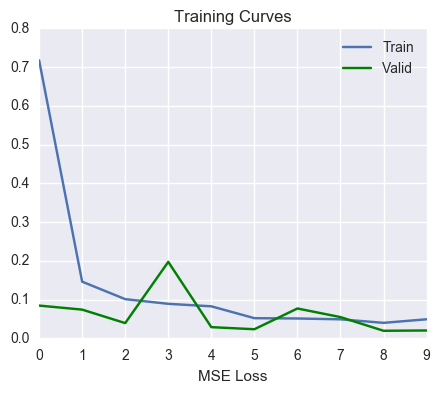

In [41]:
# Training Curves
plt.figure(figsize=(5,4))
plt.plot(log.epoch,log.history['loss'])
plt.plot(log.epoch,log.history['val_loss'],'g')
plt.title('Training Curves')
plt.xlabel('Epochs')
plt.xlabel('MSE Loss')
plt.legend(['Train','Valid'])

In [38]:
# Get Embedding by Predicting Output
x_encode = encoder.predict(x_train)

## Gaussian Process
Now, let's build a GP to predict the output

In [42]:
# GP Imports
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [43]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [45]:
gp = gaussian_process.GaussianProcess(kernel=kernel)
gp.fit(x_encode, y_train)

TypeError: __init__() got an unexpected keyword argument 'kernel'

----

In [37]:
y_predict.shape

(28576, 50)

In [ ]:
idx = np.arange(len(y_train))
plt.plot(idx,y_train.flatten())
plt.plot(idx,y_predict.flatten(),'r')

In [ ]:
print 'train', y_train.shape
print 'predt', y_predict.shape

In [ ]:
y_predict